# Protein localization
In this notebook, we'll examine the relationship between proteins that are downregulated at their organellar localization. This tests the hypothesis that "downregulation" is actually autophagy; the signature of autophagy will be if the proteins beloning to a given compartment all go down together.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.descriptivestats import sign_test
from statistics import mean

## Import data
We used [SUBA5](https://suba.live/) to get protein localization for the chloroplast, mitochondria, and peroxisome. We also have a high-quality peroxisomal protein dataset from [Reumann et al 2009](https://academic.oup.com/plphys/article/150/1/125/6107795) that we'll use to cross-check the SUBA5 results and validate our data filtering approach.

In [3]:
mito = pd.read_csv('../data/localization/Suba2022-2025-4-24_18-2_MITOCHONDRIA.csv')
mito.head(1)

,locus,chr,description,ests,flcdnas,residues,mwt,pi,gravy,gfp_image,...,location_wolfpsort,location_yloc,location_amigo,location_tair,location_swissprot,spid,location_ms,location_gfp,location_consensus,location_gs
0,AT1G01080.1,1,RNA-binding (RRM/RBD/RNP motifs) family protein;,56,3,293,32577.5,9.23574,-0.46041,0,...,plastid,plastid,nucleus:14617066;plastid:12938931;plastid:1502...,nucleus:14617066;plastid:18633119;plastid:1843...,NaN,Q8W592,golgi:25900983;nucleus:14617066;nucleus:233965...,NaN,plastid,NaN


In [4]:
chloro = pd.read_csv('../data/localization/Suba2022-2025-4-24_18-0_PLASTID.csv')
chloro.head(1)

,locus,chr,description,ests,flcdnas,residues,mwt,pi,gravy,gfp_image,...,location_wolfpsort,location_yloc,location_amigo,location_tair,location_swissprot,spid,location_ms,location_gfp,location_consensus,location_gs
0,AT1G01080.1,1,RNA-binding (RRM/RBD/RNP motifs) family protein;,56,3,293,32577.5,9.23574,-0.46041,0,...,plastid,plastid,nucleus:14617066;plastid:12938931;plastid:1502...,nucleus:14617066;plastid:18633119;plastid:1843...,NaN,Q8W592,golgi:25900983;nucleus:14617066;nucleus:233965...,NaN,plastid,NaN


In [5]:
perox = pd.read_csv('../data/localization/Suba2022-2025-4-24_18-0_PEROXISOME.csv')
perox.head(1)

,locus,chr,description,ests,flcdnas,residues,mwt,pi,gravy,gfp_image,...,location_wolfpsort,location_yloc,location_amigo,location_tair,location_swissprot,spid,location_ms,location_gfp,location_consensus,location_gs
0,AT1G01710.1,1,Acyl-CoA thioesterase family protein;,32,5,427,48157.8,7.61286,-0.22459,0,...,cytosol,peroxisome,peroxisome:17951448,peroxisome:17951448,NaN,Q8GYW7,mitochondrion:27943495;peroxisome:17951448;per...,NaN,peroxisome,NaN


In [6]:
perox_validated = pd.read_csv('../data/localization/137703Supplemental_Datarev_Reumann_etal_2009_Supp_table_3.csv')
perox_validated = perox_validated[[c for c in perox_validated.columns if 'Unnamed' not in c]]
perox_validated.head()

,Gene locus,Acronym,Annotation,MM (kDa) / pI / aa,Number of unique peptides detected,Spectral number of unique peptides,Variant information and locus identification specificity
0,At1g02920.1,GSTF7,Glutathione transferase,23.6 / 6.6 / 209,2,3,alternative locus: At1g02930.1
1,At1g04290.1,sT4,Small thioesterase isoform 4,16.9 / 8.5 / 155,5,6,NaN
2,At1g11840.1,GLX1,Glyoxalase I homolog,31.9 / 4.9 / 283,2,2,alternative loci: At1g11840.2/3/4/5; the 5th T...
3,At1g16730.1,UP6,Unknown protein,21.7 / 4.8 / 202,3,3,NaN
4,At1g19570.1,DHAR1,Dehydroascorbate reductase,23.6 / 5.8 / 213,3,3,alternative locus: At1g19570.2


In [7]:
suba = {
    'plastid': chloro,
    'mitochondrion': mito,
    'peroxisome': perox
}

## Clean data
SUBA5's search results provide several ways to decide on the location of each protein. We are particularly interested in those proteins validated by MS/MS experiments following an oganellar prep. However, some of the genes have multiple locations suggested by MS/MS. We will test a few filtering strategies, and check them against the Reumann et al data to see which corresponds best to that dataset.

Now, I would like to cross-reference the cleaned peroxisome data with the proteins from Reumann et al Sup.. Table 3 to see how well this filtering worked.

In [8]:
perox_val_list = perox_validated['Gene locus'].str.upper().tolist()
perox_val_list[:5]

['AT1G02920.1', 'AT1G04290.1', 'AT1G11840.1', 'AT1G16730.1', 'AT1G19570.1']

In [9]:
cleaned_perox = {
    'perox_only_one_ms': perox[(perox['location_ms'].str.split(';').str.len() == 1) & (perox['location_ms'].str.split(':').str[0] == 'peroxisome')],
    'perox_any_perox_ms': perox[perox['location_ms'].str.contains('peroxisome')],
    'perox_consensus': perox[perox['location_consensus'] == 'peroxisome']
}

In [10]:
for strat, p_clean in cleaned_perox.items():
    print(f'There are {len(cleaned_perox[strat])} peroxisomal proteins when SUBA dataset is cleaned by method {strat}.')
    print(f'There are {len(perox_val_list)} proxisomal proteins in the validated proteomics dataset from Reumann et al.')
    print(f'The intersection of these two datasets is {len(set(cleaned_perox[strat].locus.tolist()).intersection(set(perox_val_list)))}.')
    print('-----------------------------------------------------------------------------------------------------------------------------------')

There are 38 peroxisomal proteins when SUBA dataset is cleaned by method perox_only_one_ms.
There are 85 proxisomal proteins in the validated proteomics dataset from Reumann et al.
The intersection of these two datasets is 7.
-----------------------------------------------------------------------------------------------------------------------------------
There are 212 peroxisomal proteins when SUBA dataset is cleaned by method perox_any_perox_ms.
There are 85 proxisomal proteins in the validated proteomics dataset from Reumann et al.
The intersection of these two datasets is 83.
-----------------------------------------------------------------------------------------------------------------------------------
There are 139 peroxisomal proteins when SUBA dataset is cleaned by method perox_consensus.
There are 85 proxisomal proteins in the validated proteomics dataset from Reumann et al.
The intersection of these two datasets is 38.
-------------------------------------------------------

Unfortunately, to get high coverage of the validation set, we include a lot of false positive hits. For the moment, I am going to move ahead with the "compromise" method of using the `location_consensus` value, as it balances fewer false positives than using any peroxisomal ID in the MS data with more overlap than only allowing uniquely-peroxisomal MS proteins. I'll use the same filtering option for the other two compartment types as well.

In [11]:
cleaned_suba = {}
for organelle, results in suba.items():
    keep = results[results['location_consensus'] == organelle]
    cleaned_suba[organelle] = keep

In [12]:
for organelle, cleaned in cleaned_suba.items():
    print(f'{len(cleaned)} proteins were found for compartment {organelle}.')

1953 proteins were found for compartment plastid.
1693 proteins were found for compartment mitochondrion.
139 proteins were found for compartment peroxisome.


## Plotting differential abundance of proteins by compartment
First, read in and perform standard cleaning on our proteomics data:

In [13]:
two_vs_21 = pd.read_csv('../data/proteomics/2_vs_21_diff_abund_permutation_test_TAIR10_14Apr2025.csv', header=67)
forty_vs_21 = pd.read_csv('../data/proteomics/40_vs_21_diff_abund_permutation_test_TAIR10_14Apr2025.csv', header=67)

In [14]:
two_lfc_name = 'Log? Fold Change by Category (Set2 / Set 21)'
forty_lfc_name = 'Log? Fold Change by Category (Set 40 / Set 21)'
two_pval_col_name = "Permutation Test (p-value) Benjamini-Hochberg (p < 0.00290)"
forty_pval_col_name = "Permutation Test (p-value) Benjamini-Hochberg (p < 0.00456)"
two_pval_cutoff = 0.00290
forty_pval_cutoff = 0.00456

In [15]:
two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].replace('< 0.0001', '0.00009')
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].replace('< 0.0001', '0.00009')

two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].replace('--', np.nan)
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].replace('--', np.nan)

two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].astype('float64')
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].astype('float64')

Now, we need to separate these results by compartment:

In [16]:
two_compartments = {}
forty_compartments = {}
for compartment, members in cleaned_suba.items():
    two_compartments[compartment] = two_vs_21[two_vs_21['Accession Number'].isin(members.locus.tolist())][two_lfc_name].tolist()
    forty_compartments[compartment] = forty_vs_21[forty_vs_21['Accession Number'].isin(members.locus.tolist())][forty_lfc_name].tolist()
    print(f'{len(two_compartments[compartment])} of {len(members)} proteins were in our dataset for compartment {compartment}.')

986 of 1953 proteins were in our dataset for compartment plastid.
312 of 1693 proteins were in our dataset for compartment mitochondrion.
56 of 139 proteins were in our dataset for compartment peroxisome.


We now want to make a boxplot where we plot the log2FC of the proteins in each category, separated by oxygen concentration:

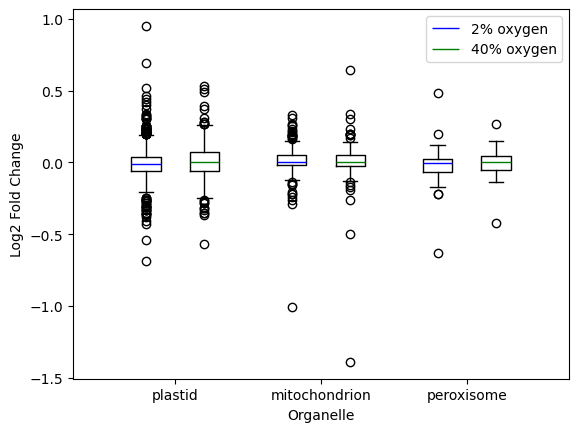

In [28]:
# X positions for the ticks
x_ticks = np.arange(3)

# Plotting the boxplots
fig, ax = plt.subplots()

positions_2 = x_ticks - 0.2
positions_40 = x_ticks + 0.2
widths = 0.2

ax.boxplot(list(two_compartments.values()), positions=positions_2, widths=widths, label='2% oxygen', medianprops=dict(color='blue'))
ax.boxplot(list(forty_compartments.values()), positions=positions_40, widths=widths, label='40% oxygen', medianprops=dict(color='green'))# Set x-axis ticks and labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(list(two_compartments.keys()))

# Add labels and title
ax.set_xlabel('Organelle')
ax.set_ylabel('Log2 Fold Change')

plt.legend()

We want to perform a statistical test on the comparisons to see if there's any meaningful difference from 0 for each population. First, check if the distributions are normal:

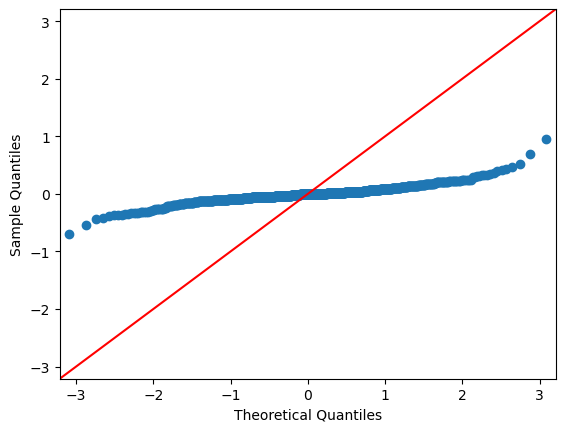

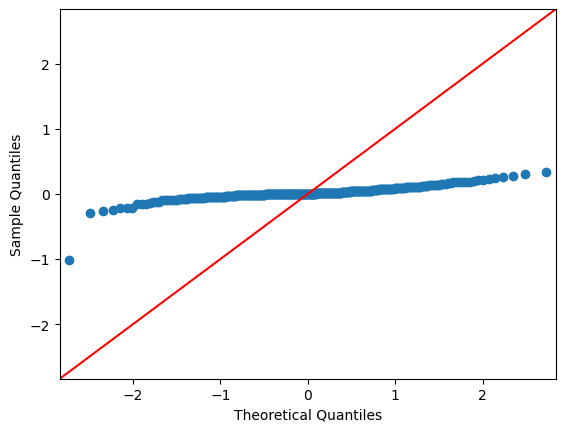

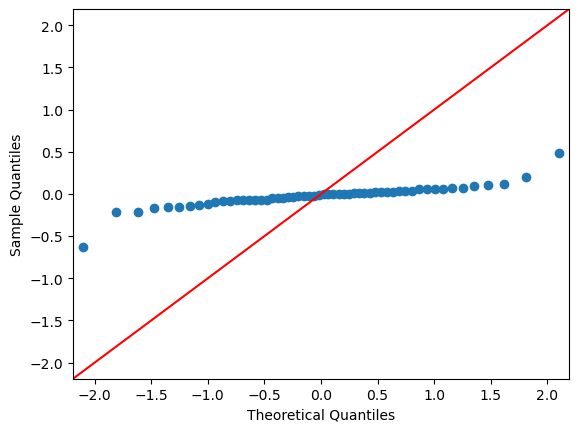

In [33]:
for organelle, vals in two_compartments.items():
    sm.qqplot(np.array(vals), line='45')

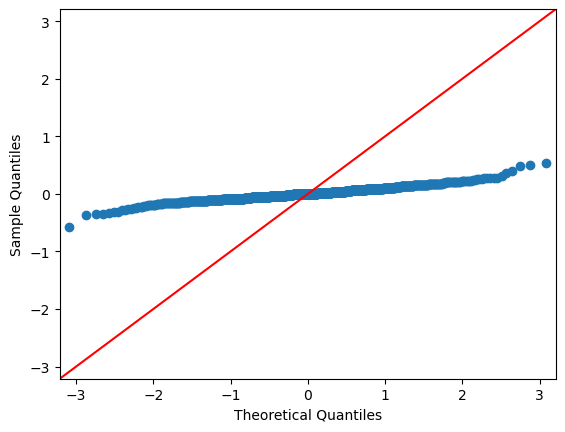

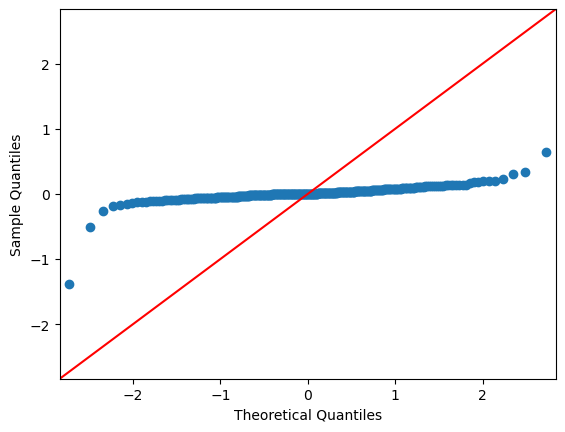

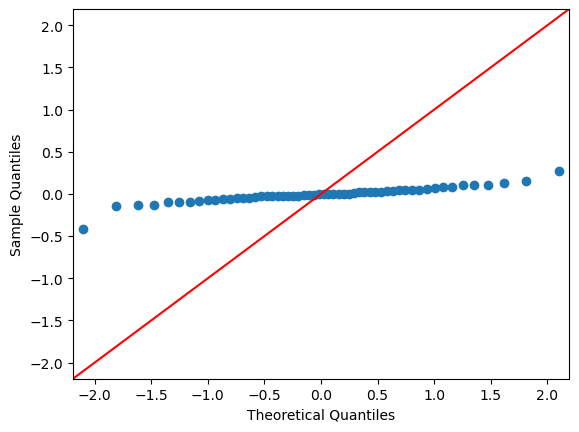

In [34]:
for organelle, vals in forty_compartments.items():
    sm.qqplot(np.array(vals), line='45')

Those distributions are definitely not normal! We'll use a sign test to test their differences:

In [46]:
print('2% oxygen')
print('------------------')
for organelle, vals in two_compartments.items():
    res = sign_test(np.array(vals))
    print(f'For organelle {organelle}, the p-value for a sign test is {res[1]:.5f}. The mean of the population is {mean(vals):.2f}')

2% oxygen
------------------
For organelle plastid, the p-value for a sign test is 0.00037. The mean of the population is -0.01
For organelle mitochondrion, the p-value for a sign test is 0.00297. The mean of the population is 0.01
For organelle peroxisome, the p-value for a sign test is 0.47989. The mean of the population is -0.02


In [47]:
print('40% oxygen')
print('------------------')
for organelle, vals in forty_compartments.items():
    res = sign_test(np.array(vals))
    print(f'For organelle {organelle}, the p-value for a sign test is {res[1]}. The mean of the population is {mean(vals):.2f}')

40% oxygen
------------------
For organelle plastid, the p-value for a sign test is 0.7390430538634167. The mean of the population is 0.00
For organelle mitochondrion, the p-value for a sign test is 0.02605017210957798. The mean of the population is 0.01
For organelle peroxisome, the p-value for a sign test is 0.5681724128491652. The mean of the population is -0.01


Interestingly, mitochondrial proteins are both significantly upregulated in comparison to the control condition. The only other significant result is that the plastid mean in 2% is significantly less than 0; however, looking at the actual means for all these groups, I am not convinced they're biologically meaningful. I would say that there is not evidence of autophagy here.